#Zadanie 4 (7 pkt)
Celem zadania jest zaimplementowanie algorytmu drzewa decyzyjnego ID3 dla zadania klasyfikacji. Trening i test należy przeprowadzić dla zbioru Iris. Proszę przeprowadzić eksperymenty najpierw dla DOKŁADNIE takiego podziału zbioru testowego i treningowego jak umieszczony poniżej. W dalszej części należy przeprowadzić analizę działania drzewa dla różnych wartości parametrów. Proszę korzystać z przygotowanego szkieletu programu, oczywiście można go modyfikować według potrzeb. Wszelkie elementy szkieletu zostaną wyjaśnione na zajęciach.

* Implementacja funkcji entropii - **0.5 pkt**
* Implementacja funkcji entropii zbioru - **0.5 pkt**
* Implementacja funkcji information gain - **0.5 pkt**
* Zbudowanie poprawnie działającego drzewa klasyfikacyjnego i przetestowanie go na wspomnianym wcześniej zbiorze testowym. Jeśli w liściu występuje kilka różnych klas, decyzją jest klasa większościowa. Policzenie accuracy i wypisanie parami klasy rzeczywistej i predykcji. - **4 pkt**
* Przeprowadzenie eksperymentów dla różnych głębokości drzew i podziałów zbioru treningowego i testowego (zmiana wartości argumentu test_size oraz usunięcie random_state). W tym przypadku dla każdego eksperymentu należy wykonać kilka uruchomień programu i wypisać dla każdego uruchomienia accuracy. - **1.5 pkt**

In [58]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt

In [62]:
def entropy_func(class_count: int, num_samples: int) -> float:
    probability = class_count / num_samples
    entropy = - probability * np.log(probability)
    return entropy

def split(data: np.ndarray, classes: np.ndarray, split_feature: int, split_val: float) -> Tuple[np.ndarray, np.ndarray]:
    dataset = np.c_[data, classes]
    feature_column = dataset[:, split_feature].astype(float)
    mask = feature_column >= split_val
    
    child_a = dataset[mask]
    child_b = dataset[~mask]
    return child_a, child_b

class Group:
    def __init__(self, group_classes):
        self.group_classes = group_classes
        self.entropy = self.group_entropy()

    def __len__(self) -> int:
        return len(self.group_classes)

    def group_entropy(self) -> float:
        entropy = 0
        class_counts = Counter(self.group_classes)
        num_samples = len(self)
        for group_class_count in class_counts.values():
            entropy += entropy_func(group_class_count, num_samples)
        return entropy

class Node:
    def __init__(self, split_feature=None, split_val=None, depth=None, child_node_a=None, child_node_b=None, val=None):
        self.split_feature = split_feature
        self.split_val = split_val
        self.depth = depth
        self.child_node_a = child_node_a
        self.child_node_b = child_node_b
        self.val = val

    def predict(self, data) -> int:
        if self.val is not None:
            return self.val
        elif data[self.split_feature] >= self.split_val:
            return self.child_node_a.predict(data)
        else:
            return self.child_node_b.predict(data)

class DecisionTreeClassifier(object):
    def __init__(self, max_depth):
        self.depth = 0
        self.max_depth = max_depth
        self.tree = None

    @staticmethod
    def get_split_entropy(group_a: Group, group_b: Group) -> float:
        split_entropy = 0
        parent_group_count = len(group_a) + len(group_b)
        child_groups = [group_a, group_b]
        for group in child_groups:
            split_entropy += (len(group) / parent_group_count) * group.group_entropy()
        return split_entropy

    def get_information_gain(self, parent_group: Group, child_group_a: Group, child_group_b: Group) -> float:
        information_gain = parent_group.group_entropy() - self.get_split_entropy(child_group_a, child_group_b)
        return information_gain

    def get_best_feature_split(self, feature_values: np.ndarray, classes: np.ndarray) -> float:
        parent = Group(classes)
        possible_thresholds = np.unique(feature_values)
        best_split_val = 0
        best_gain = 0
        
        for threshold in possible_thresholds:
            child_a, child_b = split(feature_values, classes, 0, threshold)
            if child_a.shape[0] == 0 or child_b.shape[0] == 0:
                continue
            child_a = Group(child_a[:, -1])
            child_b = Group(child_b[:, -1])
            gain = self.get_information_gain(parent, child_a, child_b)
            
            if gain >= best_gain:
                best_gain = gain
                best_split_val = threshold
        return best_split_val
    
    def get_best_split(self, data: np.ndarray, classes: np.ndarray) -> Tuple[int, float, float]:
        best_argument = 0
        best_split = 0
        best_gain = 0
        for argument in range(data.shape[1]):

            split_val = self.get_best_feature_split(data[:, argument], classes)
            child_a, child_b = split(data, classes, argument, split_val)
            child_a = Group(child_a[:, -1])
            child_b = Group(child_b[:, -1])
            gain = self.get_information_gain(Group(classes), child_a, child_b)

            if gain >= best_gain:
                best_gain = gain
                best_argument = argument
                best_split = split_val
                
        return best_argument, best_split, best_gain

    def build_tree(self, data: np.ndarray, classes: np.ndarray, depth=0) -> 'Node':
        if depth == self.max_depth or len(set(classes)) == 1:
            return Node(val=Counter(classes).most_common(1)[0][0])

        best_argument, best_split, best_gain = self.get_best_split(data, classes)
        
        child_a_data, child_b_data = split(data, classes, best_argument, best_split)
        child_a_classes = child_a_data[:, -1]
        child_b_classes = child_b_data[:, -1]
        
        child_a_node = self.build_tree(child_a_data[:, :-1], child_a_classes, depth + 1)
        child_b_node = self.build_tree(child_b_data[:, :-1], child_b_classes, depth + 1)

        return Node(split_feature=best_argument, split_val=best_split, depth=depth, child_node_a=child_a_node, child_node_b=child_b_node)

    def fit(self, data: np.ndarray, classes: np.ndarray) -> None:
        self.tree = self.build_tree(data, classes)

    def predict(self, data: np.ndarray) -> int:
        if self.tree is not None:
            return self.tree.predict(data)
    
    def evaluate(self, data: np.ndarray, classes: np.ndarray, verbose=0) -> float:
        if self.tree is not None:
            samples = len(classes)
            positively_predicted = 0
            for i, subdataset in enumerate(zip(data, classes), 1):
                sample, actual_class = subdataset
                predicted_class = self.tree.predict(sample)
                if predicted_class == actual_class:
                    positively_predicted += 1
                if verbose == 1:
                    print(f"Predicting {i:>2}/{samples}\tPrediction: {predicted_class}\tActual class: {actual_class}")
            accuracy = positively_predicted / samples
            if verbose == 1:
                print()
            print(f"Accuracy after predicting {samples} samples: {accuracy*100:.2f}%")
            return accuracy


# Testy działania WSIDecisionTreeClassifier dla zbioru treningowego Iris dla podanych parametrów

Predicting  1/15	Prediction: 0	Actual class: 1
Predicting  2/15	Prediction: 0	Actual class: 2
Predicting  3/15	Prediction: 0	Actual class: 2
Predicting  4/15	Prediction: 0	Actual class: 1
Predicting  5/15	Prediction: 0	Actual class: 0
Predicting  6/15	Prediction: 0	Actual class: 2
Predicting  7/15	Prediction: 0	Actual class: 1
Predicting  8/15	Prediction: 0	Actual class: 0
Predicting  9/15	Prediction: 0	Actual class: 0
Predicting 10/15	Prediction: 0	Actual class: 1
Predicting 11/15	Prediction: 0	Actual class: 2
Predicting 12/15	Prediction: 0	Actual class: 0
Predicting 13/15	Prediction: 0	Actual class: 1
Predicting 14/15	Prediction: 0	Actual class: 2
Predicting 15/15	Prediction: 0	Actual class: 2

Accuracy after predicting 15 samples: 26.67%
Predicting  1/15	Prediction: 1.0	Actual class: 1
Predicting  2/15	Prediction: 1.0	Actual class: 2
Predicting  3/15	Prediction: 1.0	Actual class: 2
Predicting  4/15	Prediction: 1.0	Actual class: 1
Predicting  5/15	Prediction: 0.0	Actual class: 0
Pred

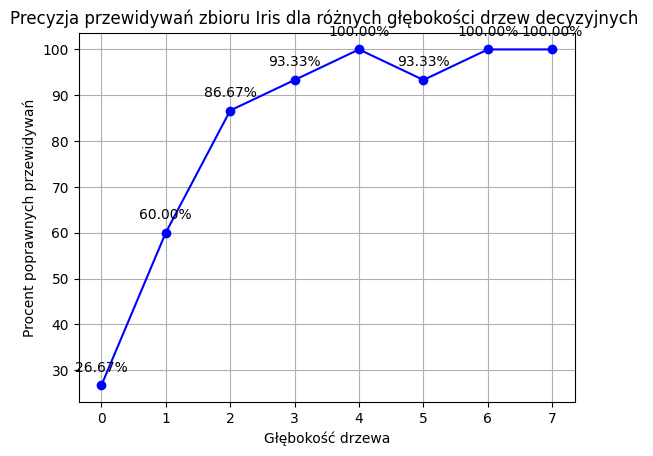

In [83]:
iris = load_iris()

x = iris.data
y = iris.target

accuracies = []
depths = []
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)

for depth in range(8):
    dc = DecisionTreeClassifier(depth)
    dc.fit(x_train, y_train)
    accuracies.append(dc.evaluate(x_test, y_test, verbose=1)*100)
    depths.append(depth)
    
plt.plot(depths,accuracies,'bo-')
for x,y in zip(depths,accuracies):
    label = f"{y:.2f}%"
    plt.annotate(label, (x,y), textcoords="offset points",  xytext=(0,10),  ha='center') 
    
plt.grid()
plt.title("Precyzja przewidywań zbioru Iris dla różnych głębokości drzew decyzyjnych ")
plt.ylabel("Procent poprawnych przewidywań")
plt.xlabel("Głębokość drzewa")
plt.show()

Na potrzeby pierwszego eksperymentu drzewa trenowane były na zbiorze Iris z podziałem: 10% danych - zbiór testowy, 90% danych - zbiór treningowy oraz zachowaniem stałego podziału wg stanu losowego random_state o wartości 123. Jak widać na wykresie wraz ze wzrostem głębokości drzewa, a co za tym idzie podziałów na podzbiory wg atrybutów dokładność przewidywań algorytmu ID3 rosła od marnej wartości 26.67% dla drzewa bez żadnego podziału - posiadające jedynie jeden liść zwracający najczęściej występującą klasę w zbiorze, przez 60% skuteczności dla głębokości 1, aż po wartość 100% skutecznośći dla drzewa o głębokości 4. 

Na wykresie możemy także zauważyć lekki spadek skuteczności dla drzewa o głękobości 5. W tym przypadku jest on tak mocno zauważalny, gdyż nasz zbiór testowy jest stosunkowo mały w liczbach bezwzględnych i jedna zła predykcja implikuje wyraźny spadek skuteczności. Widać jednak, że dla większych głębokości problem ten znika. Prawdopodobnie wynika on z chwilowego nadmiernego dopasowania się drzewa do zbioru treningowego i zbyt słaba generalizacja dla nowo widzianego zbioru.

Accuracy after predicting 8 samples: 75.00%
Accuracy after predicting 15 samples: 86.67%
Accuracy after predicting 23 samples: 95.65%
Accuracy after predicting 30 samples: 96.67%
Accuracy after predicting 38 samples: 94.74%
Accuracy after predicting 45 samples: 95.56%
Accuracy after predicting 53 samples: 96.23%
Accuracy after predicting 60 samples: 96.67%
Accuracy after predicting 68 samples: 97.06%
Accuracy after predicting 75 samples: 96.00%
Accuracy after predicting 83 samples: 96.39%
Accuracy after predicting 90 samples: 95.56%
Accuracy after predicting 98 samples: 94.90%
Accuracy after predicting 105 samples: 95.24%
Accuracy after predicting 113 samples: 94.69%
Accuracy after predicting 120 samples: 95.00%
Accuracy after predicting 128 samples: 95.31%
Accuracy after predicting 135 samples: 95.56%
Accuracy after predicting 143 samples: 90.91%
Accuracy after predicting 8 samples: 87.50%
Accuracy after predicting 15 samples: 93.33%
Accuracy after predicting 23 samples: 95.65%
Accura

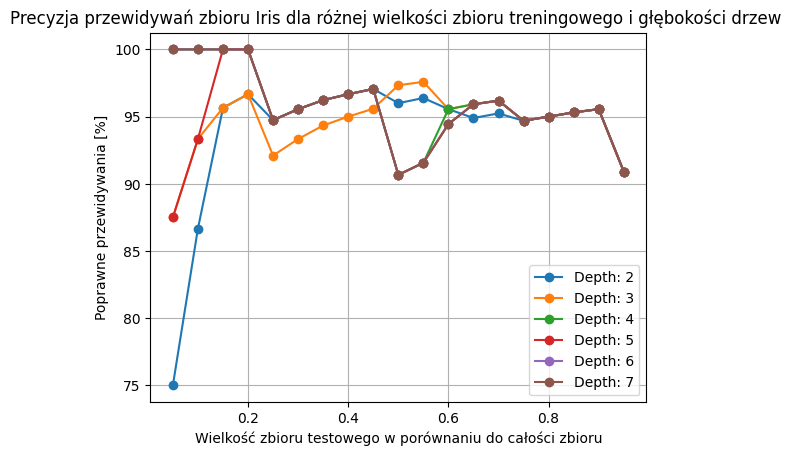

In [86]:
tries = 1
iris = load_iris()
x = iris.data
y = iris.target

for depth in range(2, 8):
    accuracies = []
    depths = []
    for test_size_mult in range(1, 20):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5*test_size_mult/10, random_state=123)
        dc = DecisionTreeClassifier(depth)
        dc.fit(x_train, y_train)
        accuracies.append(dc.evaluate(x_test, y_test, verbose=0)*100)
        depths.append(0.5*test_size_mult/10)
    
    plt.plot(depths,accuracies,'o-', label=f"Depth: {depth}")
    
plt.grid()
plt.legend()
plt.title("Precyzja przewidywań zbioru Iris dla różnej wielkości zbioru treningowego i głębokości drzew ")
plt.ylabel("Poprawne przewidywania [%]")
plt.xlabel("Wielkość zbioru testowego w porównaniu do całości zbioru")
plt.show()

W tym eksperymencie zachowano podział wg stanu losowego, jednakże postanowiono sprawdzić wpływ wielkości zbioru treningowego w stosunku do całości zbioru danych. Stopniowo zwiększano jego rozmiar od 0.05 aż do wartości 0.95. W eksperymencie zdecydowano się na sprawdzanie wyłącznie drzew o głębokości od 2 do 7, aby zagwarantować, że to własnie wielkość zbioru treningowego będzie miała kluczowy wpływ na jakość predykcji. 
Jak można zauważyć, aż do wartości 0.2 tendencje dla wszystkich modeli były niemalejące. Dopiero od wartości 0.25 można było zauważyć pierwsze oznaki przetrenowania modeli - zbytniego dopasowania się do zbioru treningowego. Wszystkie klasyfikatory zaliczyły spadki skuteczności, w tym również modele o głębokości 6 oraz 7, które dotychczas posiadały 100% skuteczność.
Następnie obserwowana była lekka poprawa, aż do wartości 0.45, kiedy to wszystkie modele o głębokości większej od 3 znów straciły na skuteczności schodząc do wartości ok. 90%. Można tutaj zauważyć ciekawą rzecz, mianowicie modele o mniejszych głębokościach tj. 2 oraz 3 okazały się odporniejsze na nadmierne dopasowanie. 

W następnych pomiarach wartości skuteczności dla wszystkich modeli uległy względnego zrównaniu w okolicach 95%, aby ostatecznie znów zbliżyć się do 90% dla podziału 0.95.

Accuracy after predicting 8 samples: 100.00%
Accuracy after predicting 8 samples: 100.00%
Accuracy after predicting 8 samples: 100.00%
Accuracy after predicting 8 samples: 100.00%
Accuracy after predicting 8 samples: 100.00%
Accuracy after predicting 8 samples: 100.00%
Accuracy after predicting 8 samples: 100.00%
Accuracy after predicting 8 samples: 100.00%
Accuracy after predicting 8 samples: 100.00%
Accuracy after predicting 8 samples: 100.00%
Accuracy after predicting 8 samples: 100.00%
Accuracy after predicting 8 samples: 100.00%
Accuracy after predicting 8 samples: 100.00%
Accuracy after predicting 8 samples: 100.00%
Accuracy after predicting 8 samples: 100.00%
Accuracy after predicting 8 samples: 87.50%
Accuracy after predicting 8 samples: 100.00%
Accuracy after predicting 8 samples: 87.50%
Accuracy after predicting 8 samples: 100.00%
Accuracy after predicting 8 samples: 100.00%
Accuracy after predicting 8 samples: 100.00%
Accuracy after predicting 8 samples: 100.00%
Accuracy aft

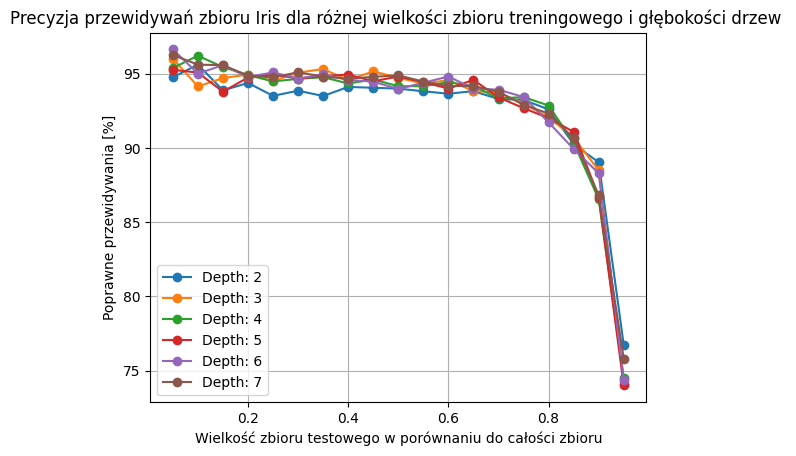

In [89]:
tries = 100
iris = load_iris()
x = iris.data
y = iris.target

for depth in range(2, 8):
    accuracies = []
    depths = []
    for test_size_mult in range(1, 20):
        temp_accuracy = []
        for i in range(tries):
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5*test_size_mult/10)
            dc = DecisionTreeClassifier(depth)
            dc.fit(x_train, y_train)
            temp_accuracy.append(dc.evaluate(x_test, y_test, verbose=0)*100)
        accuracies.append(sum(temp_accuracy)/tries)
        depths.append(0.5*test_size_mult/10)
    
    plt.plot(depths,accuracies,'o-', label=f"Depth: {depth}")
    
plt.grid()
plt.legend()
plt.title("Precyzja przewidywań zbioru Iris dla różnej wielkości zbioru treningowego i głębokości drzew ")
plt.ylabel("Poprawne przewidywania [%]")
plt.xlabel("Wielkość zbioru testowego w porównaniu do całości zbioru")
plt.show()

Aby sprawdzić rzeczywisty wpływ podziału zbioru na podzbiory treningowy oraz testowy, zdecydowano się usunąć zmienną random state i przeprowadzić wielokrotne pomiary dla każdej wielkości zbioru treningowego, a następnie wartość tą uśrednić. Pomiary rozpoczęto od wartości 0.1, aż po wartosć 0.9 z kwantem 0.1. Testowano modele o głębokościach od 2 do 7. 

Jak można zauważyć tendencja zauważona w poprzednim eksperymencie się zachowała. Najlepsze rezultaty uzyskiwano dla wartości podziału zbioru w proporcjach 1:9. Dla kolejnych podziałów z większym udziałem zbioru testowego, kosztem zbioru treningowego, zauważano stopniowe pogarszanie się modeli, spowodowane zbytnim dopasowywaniem się modeli do danych widzianych w trakcie treningu.

# Zbiór treningowy Wine z biblioteki scikit-learn

In [52]:
from sklearn.datasets import load_wine

Accuracy after predicting 18 samples: 44.44%
Accuracy after predicting 18 samples: 44.44%
Accuracy after predicting 18 samples: 33.33%
Accuracy after predicting 18 samples: 22.22%
Accuracy after predicting 18 samples: 27.78%
Accuracy after predicting 18 samples: 27.78%
Accuracy after predicting 18 samples: 27.78%
Accuracy after predicting 18 samples: 50.00%
Accuracy after predicting 18 samples: 27.78%
Accuracy after predicting 18 samples: 38.89%
Accuracy after predicting 18 samples: 16.67%
Accuracy after predicting 18 samples: 50.00%
Accuracy after predicting 18 samples: 38.89%
Accuracy after predicting 18 samples: 44.44%
Accuracy after predicting 18 samples: 50.00%
Accuracy after predicting 18 samples: 44.44%
Accuracy after predicting 18 samples: 33.33%
Accuracy after predicting 18 samples: 38.89%
Accuracy after predicting 18 samples: 38.89%
Accuracy after predicting 18 samples: 33.33%
Accuracy after predicting 18 samples: 44.44%
Accuracy after predicting 18 samples: 33.33%
Accuracy a

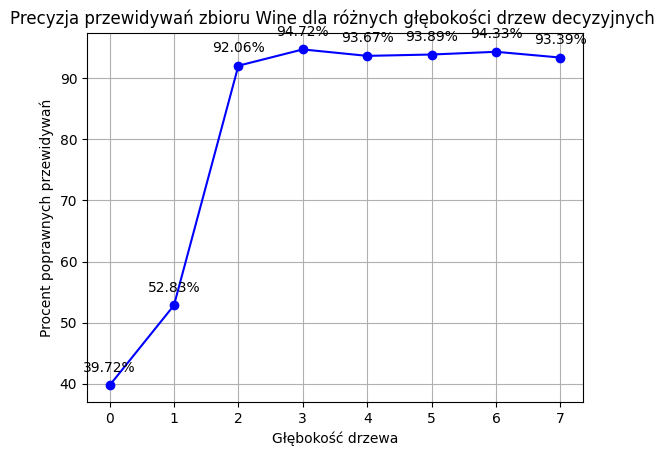

In [99]:
wine = load_wine()
x = wine.data
y = wine.target

accuracies = []
depths = []
tries = 100
for depth in range(8):
    dc = DecisionTreeClassifier(depth)
    temp_accuracy = []
    for i in range(tries):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
        dc.fit(x_train, y_train)
        temp_accuracy.append(dc.evaluate(x_test, y_test, verbose=0)*100)

    dc.fit(x_train, y_train)
    accuracies.append(sum(temp_accuracy)/tries)
    depths.append(depth)
    
plt.plot(depths,accuracies,'bo-')
for x,y in zip(depths,accuracies):
    label = f"{y:.2f}%"
    plt.annotate(label, (x,y), textcoords="offset points",  xytext=(0,10),  ha='center') 
    
plt.grid()
plt.title("Precyzja przewidywań zbioru Wine dla różnych głębokości drzew decyzyjnych ")
plt.ylabel("Procent poprawnych przewidywań")
plt.xlabel("Głębokość drzewa")
plt.show()

W tym eksperymencie sprawdzono działanie zaimplementowanego drzewa ID3 przy problemie klasyfikacji Win, korzystając ze zbioru z biblioteki scikit-learn. Jak można zauważyć dentencja jest tutaj taka sama jak w przypadku zbioru Iris, mianowicie wraz ze wzrostem głębokości drzewa otrzymujemy coraz to lepsze rezultaty predykcji, aż do głębokości 3. Ostatecznie średnio algorytm uzyskuje dla drzew o głębokości większej od 4 skuteczność utrzymującą się stabilnie na poziomie około 94%.

Accuracy after predicting 9 samples: 100.00%
Accuracy after predicting 9 samples: 100.00%
Accuracy after predicting 9 samples: 100.00%
Accuracy after predicting 9 samples: 100.00%
Accuracy after predicting 9 samples: 100.00%
Accuracy after predicting 9 samples: 77.78%
Accuracy after predicting 9 samples: 100.00%
Accuracy after predicting 9 samples: 88.89%
Accuracy after predicting 9 samples: 88.89%
Accuracy after predicting 9 samples: 88.89%
Accuracy after predicting 18 samples: 100.00%
Accuracy after predicting 18 samples: 94.44%
Accuracy after predicting 18 samples: 100.00%
Accuracy after predicting 18 samples: 100.00%
Accuracy after predicting 18 samples: 94.44%
Accuracy after predicting 18 samples: 94.44%
Accuracy after predicting 18 samples: 100.00%
Accuracy after predicting 18 samples: 100.00%
Accuracy after predicting 18 samples: 94.44%
Accuracy after predicting 18 samples: 88.89%
Accuracy after predicting 27 samples: 88.89%
Accuracy after predicting 27 samples: 88.89%
Accuracy 

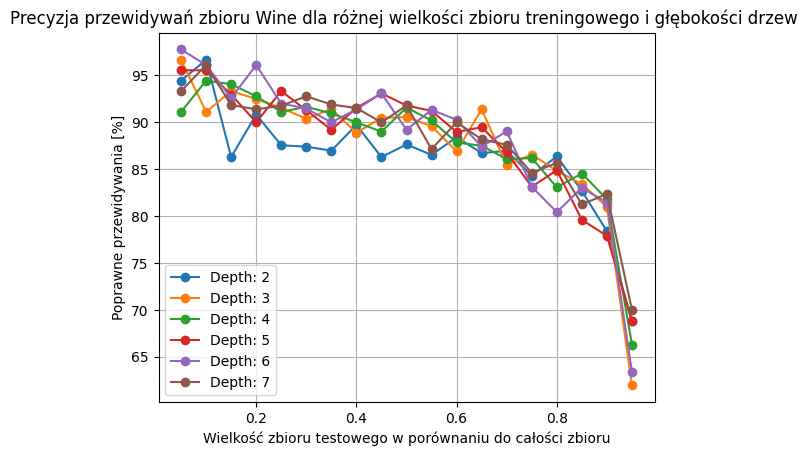

In [98]:
tries = 10
wine = load_wine()
x = wine.data
y = wine.target

for depth in range(2, 8):
    accuracies = []
    depths = []
    for test_size_mult in range(1, 20):
        temp_accuracy = []
        for i in range(tries):
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5*test_size_mult/10)
            dc = DecisionTreeClassifier(depth)
            dc.fit(x_train, y_train)
            temp_accuracy.append(dc.evaluate(x_test, y_test, verbose=0)*100)
        accuracies.append(sum(temp_accuracy)/tries)
        depths.append(0.5*test_size_mult/10)
    
    plt.plot(depths,accuracies,'o-', label=f"Depth: {depth}")
    
plt.grid()
plt.legend()
plt.title("Precyzja przewidywań zbioru Wine dla różnej wielkości zbioru treningowego i głębokości drzew ")
plt.ylabel("Poprawne przewidywania [%]")
plt.xlabel("Wielkość zbioru testowego w porównaniu do całości zbioru")
plt.show()

Tak samo jak w przypadku zbioru Iris przeprowadzono eksperyment mający wykazać wpływ zwiększania się stosunku zbioru testowego do całości zbioru danych na ostateczną skutecznosć predykcji. Na wykresie możemy zauważyć stopniowy spadek jakości działania modeli drzew ID3. Należy więc uznać, że w celu zachowania generalizacji modelu, nie powinno się przeznaczać więcej niż 20% danych na cele testów. 